In [79]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [80]:
def calc_bloom(num_nodes, rate, min_to_keep):
    n = num_nodes * rate * min_to_keep
    p = 0.001
    k = 10
    m = math.ceil((n * math.log(p)) / math.log(1 / pow(2, math.log(2))))
    return m / 8 # want bytes

In [81]:
def calc_hash_list(num_nodes, rate, min_to_keep):
    # can a list of of indices of a hash table be given instead?
#     HASH_SIZE = 8 # 64 bit hash table (sha256 does not scale AT ALL for broadcasting)
#     return HASH_SIZE * num_nodes * rate * min_to_keep

    # use a bit list of indices of a hash table with a 50% load factor
    return (2 * num_nodes * rate * min_to_keep) / 8 # want bytes

In [82]:
def find_min_poisson(min_percent, mean):
    curr_percent = 0
    count = mean
    while (curr_percent < min_percent):
        curr_percent = st.distributions.poisson.cdf(count, mean)
        count += 1
    return count

In [83]:
# bluetooth
bandwidth = 250000 # 2 Mbs in bytes/sec

# graph properties
num_nodes = 10000
degree = 10

# message properties
msg = 384

# number of messages per minute sent
rate = 2

bitlist = 6192

In [84]:
def originating(rate, ciphertext):
    return (1 / (60 / rate)) * msg

In [85]:
def forwarding_naive(num_nodes, degree, rate):
    return num_nodes * (degree + 1) * rate

In [86]:
def capacity_used(bandwidth, rate):
    return rate / bandwidth

In [87]:
def naive_broadcast(bandwidth, num_nodes, degree, msg, rate):
    rate_sec_orig = originating(rate, msg)
    rate_sec = forwarding_naive(num_nodes, degree, rate_sec_orig)
    
    return rate_sec / 125000 # want Mb/s

In [88]:
naive_broadcast(bandwidth, num_nodes, degree, msg, rate)

11.264

In [89]:
def forwarding_smart(num_nodes, degree, rate):
    # do you have? messages
    learning = (degree + 1) * bitlist
    
    # responses?
    
    # broadcasting
    broadcasting = num_nodes * rate # messages will come in or out, but only once 
                                           # (wont send and receive or receive twice)
    
    return learning + broadcasting

In [90]:
def smart_broadcast(bandwidth, num_nodes, degree, msg, rate):
    rate_sec_orig = originating(rate, msg)
    rate_sec = forwarding_smart(num_nodes, degree, rate_sec_orig)
    
    return rate_sec / 125000 # want Mb/s

In [91]:
node_sizes = range(100, 10100, 100)

# 2 message per min
naive_scales_2 = [naive_broadcast(bandwidth, x, degree, msg, 2) for x in node_sizes]
hl_scales_2 = [smart_broadcast(bandwidth, x, degree, msg, 2) for x in node_sizes]

# 4 message per min
naive_scales_4 = [naive_broadcast(bandwidth, x, degree, msg, 4) for x in node_sizes]
hl_scales_4 = [smart_broadcast(bandwidth, x, degree, msg, 4) for x in node_sizes]

# if Poisson w/ avg of 2, this should happen < 1% of the time
hl_scales_p2 = [smart_broadcast(bandwidth, x, degree, msg, 
                find_min_poisson(0.99, x * 2) / x) for x in node_sizes]

# if Poisson w/ avg of 4, this should happen < 1% of the time
hl_scales_p4 = [smart_broadcast(bandwidth, x, degree, msg, 
                find_min_poisson(0.99, x * 4) / x) for x in node_sizes]

print(calc_hash_list(10000, find_min_poisson(0.99, 10000 * 4) / 10000, 5))

50583.75000000001


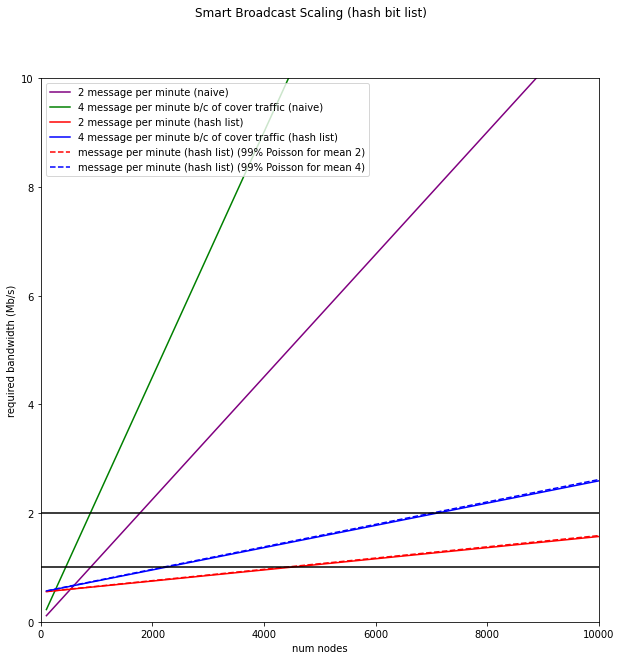

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig.suptitle('Smart Broadcast Scaling (hash bit list)')
ax.set_xlabel('num nodes')
ax.set_ylabel('required bandwidth (Mb/s)')

# naive broadcasting
ax.plot(node_sizes, naive_scales_2, color='purple', label='2 message per minute (naive)')
ax.plot(node_sizes, naive_scales_4, color='green', label='4 message per minute b/c of cover traffic (naive)')

# smart broadcasting
ax.plot(node_sizes, hl_scales_2, color='red', label='2 message per minute (hash list)')
ax.plot(node_sizes, hl_scales_4, color='blue', label='4 message per minute b/c of cover traffic (hash list)')
ax.plot(node_sizes, hl_scales_p2, color='red', linestyle='--', label='message per minute (hash list) (99% Poisson for mean 2)')
ax.plot(node_sizes, hl_scales_p4, color='blue', linestyle='--', label='message per minute (hash list) (99% Poisson for mean 4)')

ax.axhline(y=1, color='black', linestyle='-')
ax.axhline(y=2, color='black', linestyle='-')

ax.set_xlim([0,10000])
ax.set_ylim([0,10])

ax.legend()

plt.show()

In [93]:
# make a worst case line where everyone sends instantaneously at the same time

# label best worst average cases?

# how long does it take for a message to broadcast to everyone?

In [94]:
find_min_poisson(0.99, 20000)

20331

In [95]:
find_min_poisson(0.99, 40000)

40467